In Google Colab, /content/drive refers to the path within the Colab environment where Google Drive is mounted. When you mount Google Drive using the drive.mount('/content/drive') command, your Google Drive contents become accessible within the /content/drive directory in the Colab environment.

In [2]:
import torch
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import pandas as pd
from google.colab import drive
from torchvision import transforms

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist):
        self.path = path
        self.filenamelist = filenamelist
        self.labellist = labellist

    def __len__(self):
        return len(self.filenamelist)

    def __getitem__(self, idx):
        I = io.imread(self.path + self.filenamelist[idx])
        I = skimage.util.img_as_float32(I)
        I = I.reshape(1, I.shape[0], I.shape[1])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1], I.shape[2])

        label = torch.tensor(self.labellist[idx], dtype=torch.int64)
        return I, label




In [4]:
def get_dataloader(path='/content/drive/MyDrive/S224/', batch_size=32):
    df_train = pd.read_csv('/content/drive/MyDrive/S224/train.csv')
    filenamelist = df_train['filename'].values
    labellist = df_train['label'].values
    dataset_train = MyDataset(path, filenamelist, labellist)
    loader_train = torch_dataloader(dataset_train, batch_size=batch_size, num_workers=0, shuffle=True, pin_memory=True)

    df_val = pd.read_csv('/content/drive/MyDrive/S224/val.csv')
    filenamelist_val = df_val['filename'].values
    labellist_val = df_val['label'].values
    dataset_val = MyDataset(path, filenamelist_val, labellist_val)
    loader_val = torch_dataloader(dataset_val, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)

    df_test = pd.read_csv('/content/drive/MyDrive/S224/test.csv')
    filenamelist_test = df_test['filename'].values
    labellist_test = df_test['label'].values
    dataset_test = MyDataset(path, filenamelist_test, labellist_test)
    loader_test = torch_dataloader(dataset_test, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)

    return loader_train, loader_val, loader_test


In [5]:
# Use the data loader with data augmentation for training set only
loader_train, loader_val, loader_test = get_dataloader()



In [6]:
loader_train.dataset[0][0]

tensor([[[0.2275, 0.2471, 0.2353,  ..., 0.2471, 0.2471, 0.2275],
         [0.2275, 0.2510, 0.2471,  ..., 0.2471, 0.2471, 0.2314],
         [0.2275, 0.2510, 0.2471,  ..., 0.2471, 0.2510, 0.2314],
         ...,
         [0.4000, 0.3804, 0.3059,  ..., 0.3804, 0.3098, 0.2588],
         [0.3608, 0.4353, 0.4118,  ..., 0.2902, 0.2706, 0.2510],
         [0.2863, 0.3686, 0.4235,  ..., 0.2706, 0.2745, 0.2510]],

        [[0.2275, 0.2471, 0.2353,  ..., 0.2471, 0.2471, 0.2275],
         [0.2275, 0.2510, 0.2471,  ..., 0.2471, 0.2471, 0.2314],
         [0.2275, 0.2510, 0.2471,  ..., 0.2471, 0.2510, 0.2314],
         ...,
         [0.4000, 0.3804, 0.3059,  ..., 0.3804, 0.3098, 0.2588],
         [0.3608, 0.4353, 0.4118,  ..., 0.2902, 0.2706, 0.2510],
         [0.2863, 0.3686, 0.4235,  ..., 0.2706, 0.2745, 0.2510]],

        [[0.2275, 0.2471, 0.2353,  ..., 0.2471, 0.2471, 0.2275],
         [0.2275, 0.2510, 0.2471,  ..., 0.2471, 0.2471, 0.2314],
         [0.2275, 0.2510, 0.2471,  ..., 0.2471, 0.2510, 0.

In [7]:
loader_train.dataset[0][0][0]

tensor([[0.2275, 0.2471, 0.2353,  ..., 0.2471, 0.2471, 0.2275],
        [0.2275, 0.2510, 0.2471,  ..., 0.2471, 0.2471, 0.2314],
        [0.2275, 0.2510, 0.2471,  ..., 0.2471, 0.2510, 0.2314],
        ...,
        [0.4000, 0.3804, 0.3059,  ..., 0.3804, 0.3098, 0.2588],
        [0.3608, 0.4353, 0.4118,  ..., 0.2902, 0.2706, 0.2510],
        [0.2863, 0.3686, 0.4235,  ..., 0.2706, 0.2745, 0.2510]])

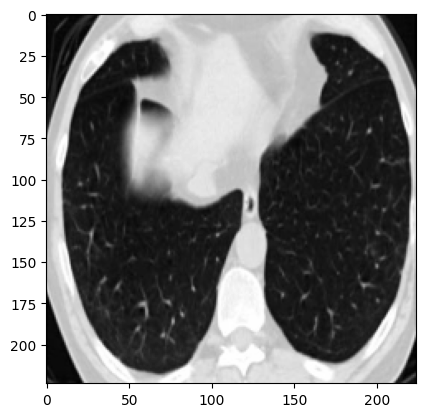

In [8]:
plt.imshow(loader_train.dataset[0][0][0].numpy(), cmap='gray')

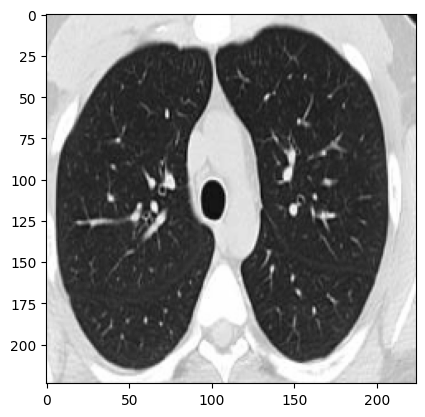

In [9]:
plt.imshow(loader_test.dataset[0][0][0].numpy(), cmap='gray')

In [10]:
loader_train, loader_test

(<torch.utils.data.dataloader.DataLoader at 0x7ccebd4c7a30>,
 <torch.utils.data.dataloader.DataLoader at 0x7ccebd4c5360>)

In [11]:
len(loader_train),len(loader_val),len(loader_test)

(64, 2, 13)

In [12]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.utils.data import DataLoader as torch_dataloader
import torchvision
from torchvision import datasets, transforms
import torchvision.models as tv_models

In [13]:
from torchvision.models import ResNet50_Weights
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #use resnet50 as the base model
        self.resnet50 = tv_models.resnet50(weights=ResNet50_Weights.DEFAULT)
        #modified the last layer for binary classification-the output will be just a number: 0 or 1
        self.resnet50.fc=torch.nn.Linear(2048, 1)
        #freeze all parameters
        for p in self.resnet50.parameters():
            p.requires_grad = False
        #set the parameters of layer4 to be trainable

        for p in self.resnet50.layer4.parameters():
            p.requires_grad = True

        #set the parameters of fc to be trainable
        for p in self.resnet50.fc.parameters():
            p.requires_grad = True
    def get_trainable_parameters(self):
        pList=list(list(self.resnet50.fc.parameters())+list(self.resnet50.layer4.parameters()))
        return pList
    def forward(self,x):
        z = self.resnet50(x)
        z = z.view(-1)
        return z

In [14]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [15]:
tv_models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
def train(model, device, optimizer, dataloader, epoch):
    model.train()#set model to training mode
    loss_train=0
    acc_train =0
    for batch_idx, (X, Y) in enumerate(dataloader):
        #print(X.shape, Y.shape)
        #print(X.dtype, Y.dtype)
        Y = Y.to(X.dtype)
        X, Y = X.to(device), Y.to(device)
        Z = model(X)#forward pass
        loss = nnF.binary_cross_entropy_with_logits(Z, Y)
        optimizer.zero_grad()#clear grad of each parameter
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        Yp = (Z.data > 0).to(torch.int64)
        Y = Y.to(torch.int64)
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset)
    return loss_train, acc_train

In [17]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0
    Confusion=np.zeros((2,2))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):
            Y = Y.to(X.dtype)
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)
            loss_test+=loss.item()
            Yp = (Z.data > 0).to(torch.int64)
            Y = Y.to(torch.int64)
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 2):
                for j in range(0, 2):
                    Confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    loss_test/=len(dataloader)
    acc_test/=len(dataloader.dataset)
    Sens=np.zeros(2)
    Prec=np.zeros(2)
    for n in range(0, 2):
        TP=Confusion[n,n]
        FN=np.sum(Confusion[n,:])-TP
        FP=np.sum(Confusion[:,n])-TP
        Sens[n]=TP/(TP+FN)
        Prec[n]=TP/(TP+FP)
    Acc = Confusion.diagonal().sum()/Confusion.sum() # should be the same as acc_test
    return loss_test, acc_test, (Confusion, Acc, Sens, Prec)

In [18]:
from torchvision import datasets, transforms


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)
model=Net()
model.to(device)
#optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.99)
#---------------------------------------------------------
#x,label=dataset_train.__getitem__(0)
#x=x.view(1,3,224,224).to(device)
#z=model(x)
#
#run this whenever creating a new model
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

device cuda:0


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s]


In [20]:
def plot_result(loss_train_list, acc_train_list,
                loss_val_list, acc_val_list):
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    #ax[0].set_xticks(np.arange(len(loss_train_list)))
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    #ax[1].set_xticks(np.arange(len(loss_train_list)))
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

In [21]:
lr_new=0.0001
for g in optimizer.param_groups:
    g['lr']=lr_new

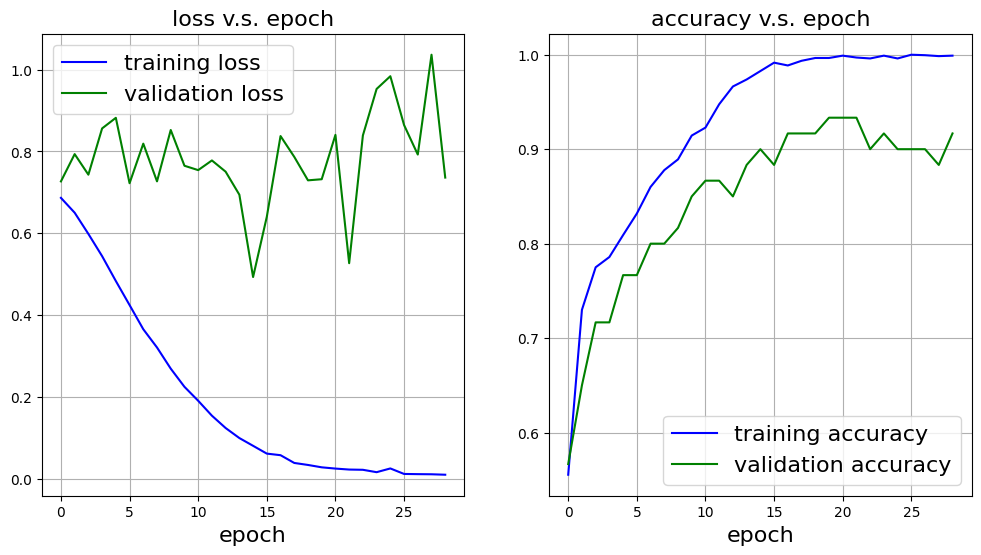

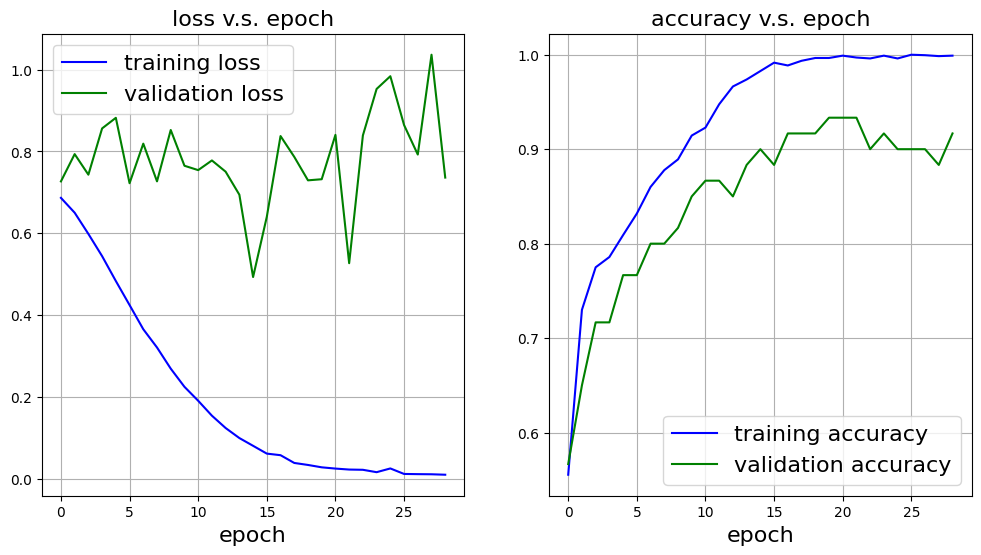

In [22]:
for epoch in range(epoch_save+1, epoch_save+30):
    t0=time.time()
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    t1=time.time()
    print("time cost", t1-t0)
    #-------- validation --------------------------------
    loss_val, acc_val, other_val = test(model, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list,
              loss_val_list, acc_val_list, other_val)
    save_checkpoint('CNN_LS_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list,
                          loss_val_list, acc_val_list)
    display.display(fig)

In [23]:
best_id= np.argmax(acc_val_list)
best_id

19

In [24]:
epoch_save=best_id
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint=torch.load('CNN_LS_Pytorch_epoch'+str(epoch_save)+'.pt', map_location=device)
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
#
#optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99)
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#
(loss_train_list, acc_train_list,
 loss_val_list, acc_val_list, other_val) = checkpoint['result']

In [25]:
loss_test, acc_test, (Confusion, Acc, Sens, Prec) = test(model, device, loader_test)
Confusion_sens=Confusion.copy()
for n in range(0, 2):
    Confusion_sens[n,:]/=np.sum(Confusion[n,:])
Confusion_prec=Confusion.copy()
for n in range(0, 2):
    Confusion_prec[:,n]/=np.sum(Confusion[:,n])
print('Accuracy (average)', acc_test)
print('Accuracy (average)', Acc)
print('Sensitivity', Sens)
print('Precision', Prec)
print('Confusion_sens \n', Confusion_sens)
print('Confusion_prec \n', Confusion_prec)

Accuracy (average) 0.9475
Accuracy (average) 0.9475
Sensitivity [0.96  0.935]
Precision [0.93658537 0.95897436]
Confusion_sens 
 [[0.96  0.04 ]
 [0.065 0.935]]
Confusion_prec 
 [[0.93658537 0.04102564]
 [0.06341463 0.95897436]]


In [ ]:
# TRANSFER LEARNING IS MUCH FASTER, THIS IS A HUGE BENEFIT.

In [26]:
pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5248 sha256=9d5be84e2e8ecd5793b9d006154e95707119d7391e4b5f51db409deae9868154
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


In [27]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=f569ede4087a52b12428b3ae371b8eecab6e34df18031a7f395ceb71ebf30f58
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [117]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image


In [135]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        #print('model_output', model_output)
        #print('model_output.shape', model_output.shape)
        #print('len(model_output.shape)', len(model_output.shape))
        if len(model_output.shape) == 0:
            return model_output
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

In [96]:
#model.resnet50

In [29]:
model.resnet50.fc

Linear(in_features=2048, out_features=1, bias=True)

In [119]:
target_layers = [model.resnet50.layer4[-1]]

In [161]:
image=loader_test.dataset[10][0].permute(1,2,0).numpy()
image.shape

(224, 224, 3)

In [164]:
image1=loader_test.dataset[325][0].permute(1,2,0).numpy()


In [165]:
loader_test.dataset[325][0]

tensor([[[0.7529, 0.7647, 0.7647,  ..., 0.7686, 0.8039, 0.7922],
         [0.7765, 0.7922, 0.7922,  ..., 0.8078, 0.8353, 0.8118],
         [0.7882, 0.7961, 0.7922,  ..., 0.8078, 0.8275, 0.8000],
         ...,
         [0.7804, 0.8000, 0.8118,  ..., 0.8314, 0.7961, 0.8118],
         [0.8039, 0.8157, 0.8000,  ..., 0.7961, 0.7804, 0.7765],
         [0.7922, 0.7765, 0.7608,  ..., 0.7412, 0.7608, 0.7529]],

        [[0.7529, 0.7647, 0.7647,  ..., 0.7686, 0.8039, 0.7922],
         [0.7765, 0.7922, 0.7922,  ..., 0.8078, 0.8353, 0.8118],
         [0.7882, 0.7961, 0.7922,  ..., 0.8078, 0.8275, 0.8000],
         ...,
         [0.7804, 0.8000, 0.8118,  ..., 0.8314, 0.7961, 0.8118],
         [0.8039, 0.8157, 0.8000,  ..., 0.7961, 0.7804, 0.7765],
         [0.7922, 0.7765, 0.7608,  ..., 0.7412, 0.7608, 0.7529]],

        [[0.7529, 0.7647, 0.7647,  ..., 0.7686, 0.8039, 0.7922],
         [0.7765, 0.7922, 0.7922,  ..., 0.8078, 0.8353, 0.8118],
         [0.7882, 0.7961, 0.7922,  ..., 0.8078, 0.8275, 0.

In [166]:
loader_test.dataset

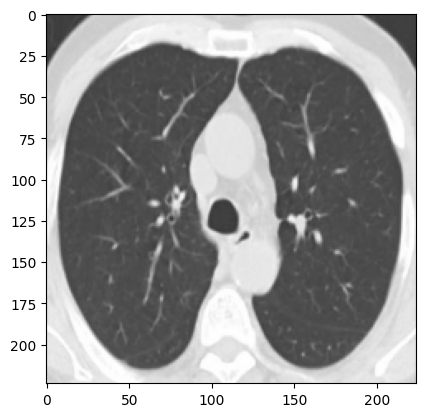

In [167]:
plt.imshow(image,cmap='gray')

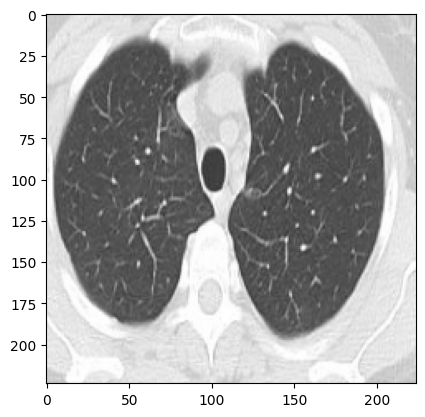

In [168]:
plt.imshow(image1,cmap='gray')

In [170]:
image_input=loader_test.dataset[10][0]
image_input.shape

torch.Size([3, 224, 224])

In [171]:
image_input66=loader_test.dataset[325][0]
image_input66.shape

torch.Size([3, 224, 224])

In [172]:
image_input = image_input.to(device)

In [173]:
image_input66 = image_input66.to(device)

In [174]:
image_input.shape

torch.Size([3, 224, 224])

In [175]:
image_input66.shape

torch.Size([3, 224, 224])

In [176]:
image_input1 = image_input.unsqueeze(0)
image_input1.shape

torch.Size([1, 3, 224, 224])

In [177]:
image_input661 = image_input.unsqueeze(0)
image_input661.shape

torch.Size([1, 3, 224, 224])

In [178]:
model_output=model(image_input1)
model_output.shape

torch.Size([1])

In [180]:
model_output66=model(image_input661)
model_output66.shape

torch.Size([1])

In [181]:
len(model_output)

1

In [182]:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

In [183]:
image_input1.shape

torch.Size([1, 3, 224, 224])

In [184]:
targets = [ClassifierOutputTarget(category=0)]
grayscale_cam = cam(input_tensor=image_input1, targets=targets)

In [185]:
grayscale_cam.shape

(1, 224, 224)

In [186]:
image.shape

(224, 224, 3)

In [189]:
cam_image = show_cam_on_image(image1, grayscale_cam[0], use_rgb=True)

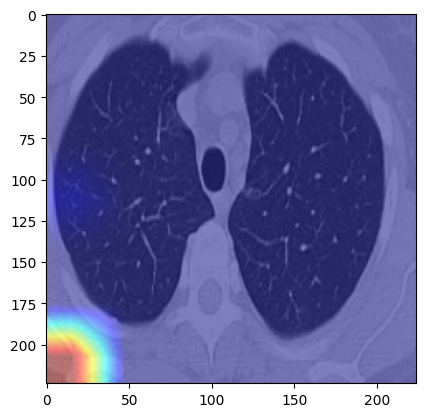

In [190]:
plt.imshow(cam_image)

In [191]:
cam_image = show_cam_on_image(image, grayscale_cam[0], use_rgb=True)

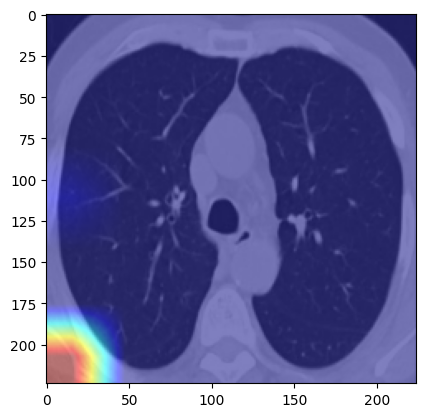

In [192]:
plt.imshow(cam_image)